In [48]:
import pandas as pd

LB = pd.read_csv("LB_position.csv")

LB.head(10)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,176676,Marcelo,30,Brazil,88,88,Real Madrid,€43M,€285K,Left,...,86.0,71.0,85.0,86.0,12.0,5.0,5.0,5.0,9.0,€88.2M
1,189332,Jordi Alba,29,Spain,87,87,FC Barcelona,€38M,€250K,Left,...,79.0,72.0,84.0,85.0,13.0,15.0,13.0,6.0,13.0,€77.9M
2,191043,Alex Sandro,27,Brazil,86,86,Juventus,€36.5M,€160K,Left,...,82.0,81.0,84.0,84.0,7.0,7.0,9.0,12.0,5.0,€60.2M
3,197445,D. Alaba,26,Austria,85,87,FC Bayern München,€38M,€110K,Left,...,79.0,80.0,82.0,80.0,5.0,7.0,14.0,15.0,9.0,€65.6M
4,164169,Filipe Luís,32,Brazil,85,85,Atlético Madrid,€21.5M,€81K,Left,...,88.0,78.0,84.0,86.0,11.0,15.0,9.0,9.0,5.0,€44.1M
5,212462,Alex Telles,25,Brazil,84,87,FC Porto,€32M,€22K,Left,...,80.0,80.0,81.0,79.0,13.0,8.0,12.0,11.0,14.0,€66.4M
6,192638,Marcos Alonso,27,Spain,83,84,Chelsea,€24M,€130K,Left,...,76.0,79.0,82.0,79.0,9.0,7.0,13.0,9.0,12.0,€46.2M
7,220814,L. Hernández,22,France,82,88,Atlético Madrid,€25.5M,€53K,Left,...,76.0,76.0,83.0,86.0,10.0,7.0,8.0,14.0,10.0,€57.4M
8,216267,A. Robertson,24,Scotland,82,87,Liverpool,€24.5M,€98K,Left,...,73.0,80.0,81.0,78.0,11.0,8.0,10.0,7.0,14.0,€48.4M
9,185103,A. Kolarov,32,Serbia,82,82,Roma,€12.5M,€73K,Left,...,88.0,81.0,82.0,81.0,16.0,15.0,8.0,16.0,6.0,€21.3M


In [49]:
LB = LB.drop(['Nationality','Overall','Club','International Reputation','Work Rate','Body Type',
                           'Jersey Number','Joined','Loaned From','Contract Valid Until','GKDiving','GKHandling','GKKicking',
                           'GKPositioning','GKReflexes','Release Clause','Positioning'], axis=1)


LB.head(10)

,ID,Name,Age,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,Position,...,Strength,LongShots,Aggression,Interceptions,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,176676,Marcelo,30,88,€43M,€285K,Left,4.0,5.0,LB,...,78.0,70.0,84.0,85.0,82.0,59.0,86.0,71.0,85.0,86.0
1,189332,Jordi Alba,29,87,€38M,€250K,Left,3.0,3.0,LB,...,61.0,66.0,75.0,84.0,70.0,59.0,79.0,72.0,84.0,85.0
2,191043,Alex Sandro,27,86,€36.5M,€160K,Left,3.0,3.0,LB,...,79.0,72.0,82.0,82.0,70.0,60.0,82.0,81.0,84.0,84.0
3,197445,D. Alaba,26,87,€38M,€110K,Left,4.0,3.0,LB,...,71.0,82.0,69.0,84.0,77.0,80.0,79.0,80.0,82.0,80.0
4,164169,Filipe Luís,32,85,€21.5M,€81K,Left,3.0,3.0,LB,...,74.0,60.0,81.0,84.0,70.0,65.0,88.0,78.0,84.0,86.0
5,212462,Alex Telles,25,87,€32M,€22K,Left,2.0,3.0,LB,...,68.0,75.0,78.0,80.0,74.0,68.0,80.0,80.0,81.0,79.0
6,192638,Marcos Alonso,27,84,€24M,€130K,Left,3.0,3.0,LB,...,76.0,77.0,75.0,79.0,69.0,64.0,76.0,79.0,82.0,79.0
7,220814,L. Hernández,22,88,€25.5M,€53K,Left,3.0,3.0,LB,...,76.0,47.0,86.0,81.0,61.0,34.0,76.0,76.0,83.0,86.0
8,216267,A. Robertson,24,87,€24.5M,€98K,Left,2.0,3.0,LB,...,66.0,60.0,78.0,80.0,74.0,55.0,73.0,80.0,81.0,78.0
9,185103,A. Kolarov,32,82,€12.5M,€73K,Left,3.0,3.0,LB,...,77.0,83.0,85.0,81.0,77.0,74.0,88.0,81.0,82.0,81.0


In [50]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
LB['Preferred Foot'] =label_encoder.fit_transform(LB['Preferred Foot'])
LB['Position'] =label_encoder.fit_transform(LB['Position'])

def convert_height_to_cm(height):
    try:
        feet, inches = map(int, height.split("'"))
        total_inches = feet * 12 + inches
        height_cm = total_inches * 2.54
        return round(height_cm, 2)
    except Exception as e:
        print(f"Error converting height: {e}")
        return None
    
def convert_weight_to_kg(weight):
    try:
        # Remove 'lbs' from the string and convert to float
        weight_kg = float(weight.replace('lbs', '').strip()) * 0.453592
        return round(weight_kg, 2)
    except Exception as e:
        print(f"Error converting weight: {e}")
        return None

# Applying the conversion functions
LB['Height'] = LB['Height'].apply(convert_height_to_cm)
LB['Weight'] = LB['Weight'].apply(convert_weight_to_kg)

# Function to convert Value and Wage
def convert_value_wage(value):
    if value[-1] == 'M':
        return float(value[1:-1]) * 1e6
    elif value[-1] == 'K':
        return float(value[1:-1]) * 1e3
    return float(value[1:])

# Apply conversion
LB['Value'] = LB['Value'].apply(convert_value_wage).astype(int)
LB['Wage'] = LB['Wage'].apply(convert_value_wage).astype(int)

LB.head(10)

,ID,Name,Age,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,Position,...,Strength,LongShots,Aggression,Interceptions,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,176676,Marcelo,30,88,43000000,285000,0,4.0,5.0,0,...,78.0,70.0,84.0,85.0,82.0,59.0,86.0,71.0,85.0,86.0
1,189332,Jordi Alba,29,87,38000000,250000,0,3.0,3.0,0,...,61.0,66.0,75.0,84.0,70.0,59.0,79.0,72.0,84.0,85.0
2,191043,Alex Sandro,27,86,36500000,160000,0,3.0,3.0,0,...,79.0,72.0,82.0,82.0,70.0,60.0,82.0,81.0,84.0,84.0
3,197445,D. Alaba,26,87,38000000,110000,0,4.0,3.0,0,...,71.0,82.0,69.0,84.0,77.0,80.0,79.0,80.0,82.0,80.0
4,164169,Filipe Luís,32,85,21500000,81000,0,3.0,3.0,0,...,74.0,60.0,81.0,84.0,70.0,65.0,88.0,78.0,84.0,86.0
5,212462,Alex Telles,25,87,32000000,22000,0,2.0,3.0,0,...,68.0,75.0,78.0,80.0,74.0,68.0,80.0,80.0,81.0,79.0
6,192638,Marcos Alonso,27,84,24000000,130000,0,3.0,3.0,0,...,76.0,77.0,75.0,79.0,69.0,64.0,76.0,79.0,82.0,79.0
7,220814,L. Hernández,22,88,25500000,53000,0,3.0,3.0,0,...,76.0,47.0,86.0,81.0,61.0,34.0,76.0,76.0,83.0,86.0
8,216267,A. Robertson,24,87,24500000,98000,0,2.0,3.0,0,...,66.0,60.0,78.0,80.0,74.0,55.0,73.0,80.0,81.0,78.0
9,185103,A. Kolarov,32,82,12500000,73000,0,3.0,3.0,0,...,77.0,83.0,85.0,81.0,77.0,74.0,88.0,81.0,82.0,81.0


In [51]:
LB['Passing'] = LB['Crossing']  +LB['ShortPassing'] +LB['LongPassing']

LB['Ball_Control'] =  LB['Dribbling']  +LB['BallControl'] +LB['Composure'] +LB['HeadingAccuracy'] 

LB['Fitness'] = LB['Acceleration'] +LB['SprintSpeed'] +LB['Agility'] +LB['Reactions'] +LB['Balance'] +LB['Jumping'] +LB['Stamina'] +LB['Strength'] +LB['Aggression'] +LB['Vision']

LB['Defensive_abilities'] =LB['Interceptions'] +LB['Marking']  +LB['StandingTackle']  +LB['SlidingTackle'] 

LB['Shooting'] = LB['Curve'] +LB['FKAccuracy'] +LB['Finishing'] +LB['Penalties'] +LB['LongShots'] 

LB = LB [['Name','ID','Passing','Ball_Control','Value','Fitness','Defensive_abilities','Potential','Weight','Shooting','Age']]
LB.head(10)

,Name,ID,Passing,Ball_Control,Value,Fitness,Defensive_abilities,Potential,Weight,Shooting,Age
0,Marcelo,176676,250.0,343.0,43000000,836.0,327.0,88,79.83,351.0,30
1,Jordi Alba,189332,245.0,313.0,38000000,822.0,325.0,87,68.04,341.0,29
2,Alex Sandro,191043,236.0,319.0,36500000,812.0,331.0,86,79.83,324.0,27
3,D. Alaba,197445,243.0,316.0,38000000,791.0,326.0,87,76.20,387.0,26
4,Filipe Luís,164169,243.0,320.0,21500000,758.0,332.0,85,73.94,333.0,32
5,Alex Telles,212462,258.0,318.0,32000000,788.0,320.0,87,71.21,374.0,25
6,Marcos Alonso,192638,242.0,321.0,24000000,732.0,319.0,84,87.09,380.0,27
7,L. Hernández,220814,221.0,303.0,25500000,769.0,326.0,88,76.20,204.0,22
8,A. Robertson,216267,230.0,290.0,24500000,766.0,319.0,87,63.96,276.0,24
9,A. Kolarov,185103,245.0,323.0,12500000,751.0,325.0,82,83.01,383.0,32


In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from itertools import product
from sklearn.linear_model import Ridge

x = LB.drop(['Name','ID', 'Potential'], axis=1)
y = LB['Potential']

# Now split the cleaned data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [53]:
import CombinedModle

# Assuming your data is already loaded and split into x_train, y_train, x_test, y_test
Combine_test, Combine_train = CombinedModle.train_and_evaluate(x_train, y_train, x_test, y_test)

Combined R^2 Test: 0.907254747822139
Combined R^2 Train: 0.9705131588064105


In [54]:
import PlayerPotential

# Assuming you have CB, x_test, y_test, and Combine_test from the previous steps
top_players = PlayerPotential.get_top_players(LB, x_test, y_test, Combine_test, top_n=10)

# Print the top 10 players
print(top_players)

KeyError: 'Predicted_Potential'

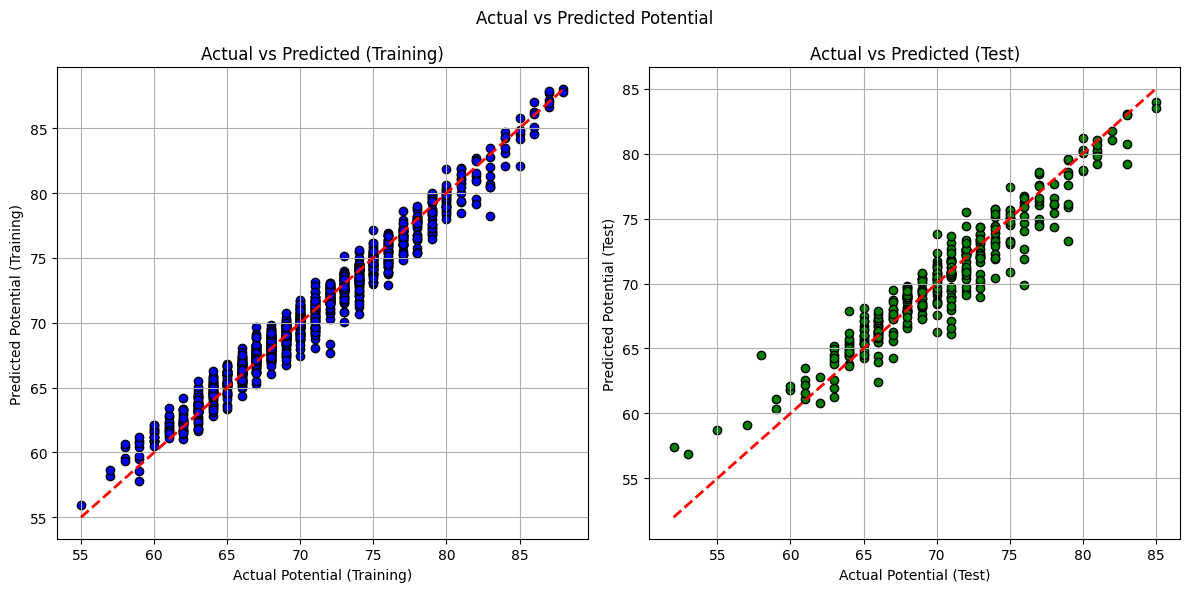

In [8]:
from plot_utils import Plot_actual_vs_predicted

Plot_actual_vs_predicted(y_train, y_test, Combine_train, Combine_test)